In [3]:
import math
import copy
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from collections import defaultdict
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold
from pandas_profiling import ProfileReport

## Task description

### TASK 2: HEART RHYTHM CLASSIFICATION FROM RAW ECG SIGNALS

While the previous projects dealt with medical image features, we turn now to the classification of entire time series into one of 4 classes. This time you will work with the original ECG recordings of different length sampled as 300Hz to predict heart rhythm.

In [4]:
x_train = pd.read_csv("data/X_train.csv")
x_train

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806
0,0,-13,-9,-6,-4,0,2,6,12,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-34,110,249,390,527,639,721,777,823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-34,-36,-37,-39,-41,-42,-44,-46,-48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,292,298,303,310,320,336,354,377,405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,157,179,195,210,217,222,226,228,231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,5112,-247,-271,-285,-303,-334,-376,-413,-432,-443,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5113,5113,62,62,61,61,61,61,61,61,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5114,5114,-95,-110,-124,-131,-126,-114,-95,-67,-42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5115,5115,-50,-48,-45,-42,-38,-35,-32,-30,-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
x_test = pd.read_csv("data/X_test.csv")
x_test

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806
0,0,73,73,73,72,70,68,66,63,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-100,-97,-95,-94,-94,-93,-93,-93,-92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-571,-656,-756,-833,-893,-952,-1000,-1061,-1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,-44,-41,-39,-37,-35,-34,-33,-32,-32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,-68,-70,-73,-76,-78,-80,-81,-82,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,3406,8,8,9,11,13,13,13,13,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3407,3407,104,73,42,17,0,-12,-17,-20,-24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3408,3408,-42,-38,-34,-30,-27,-24,-21,-18,-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3409,3409,12,8,4,0,-3,-8,-12,-15,-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
y_train = pd.read_csv("data/y_train.csv")
y_train

,id,y
0,0,0
1,1,0
2,2,0
3,3,1
4,4,2
...,...,...
5112,5112,3
5113,5113,0
5114,5114,0
5115,5115,0


In [47]:
SAMPLING_RATE = 300

def plot_row(df, row_idx):
    seq = df.loc[row_idx].dropna()[1:]
    signals, info = nk.ecg_process(
        seq, 
        sampling_rate=SAMPLING_RATE, 
        method="neurokit"
    )
    cleaned_ecg = signals["ECG_Clean"]
    epochs = nk.ecg_segment(
        cleaned_ecg, 
        rpeaks=None, 
        sampling_rate=SAMPLING_RATE, 
        show=True
    )
    _, rpeaks = nk.ecg_peaks(
        cleaned_ecg, 
        sampling_rate=SAMPLING_RATE
    )
    _, waves_peak = nk.ecg_delineate(
        cleaned_ecg, 
        rpeaks, 
        sampling_rate=SAMPLING_RATE, 
        method="dwt", 
        show=True, 
        show_type='peaks'
    )
    
    analysis = nk.ecg_analyze(
        signals, 
        sampling_rate=SAMPLING_RATE, 
        method="interval-related"
    )
    display(analysis)
    print(analysis.to_dict().keys())

### Train data visualization

,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,73.847519,815.858586,65.382662,NaN,NaN,NaN,NaN,NaN,NaN,63.711422,...,0.45257,4.141017,0.385663,0.216039,0.38092,0.355285,0.790085,1.70428,1.194765,0.457909


dict_keys(['ECG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_Asymmetry', 'HRV_MFDFA_alpha1_Fluctuation', 'HRV_MFDFA_alpha1_Increment', 'HRV_ApE

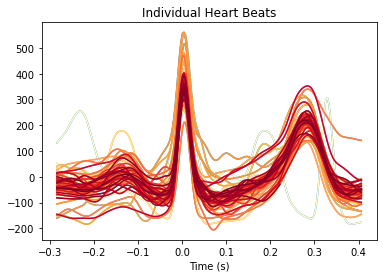

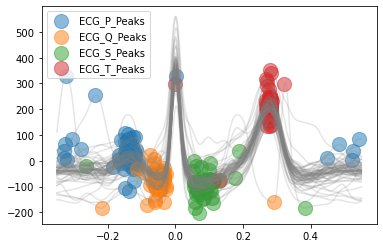

In [48]:
# class 0
plot_row(x_train, 0)

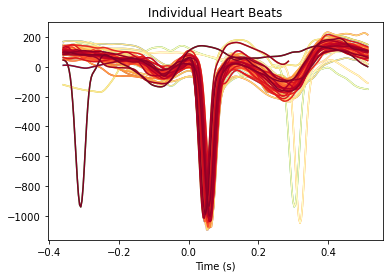

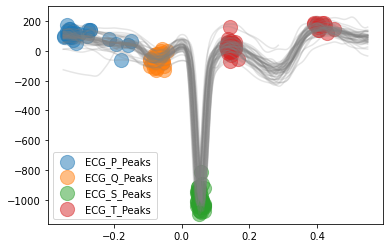

In [10]:
# class 0 (flipped)
plot_row(x_train, 42)

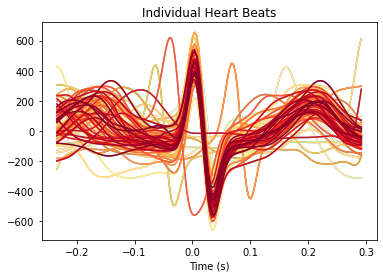

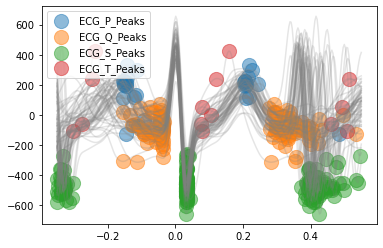

In [11]:
# class 1
plot_row(x_train, 3)

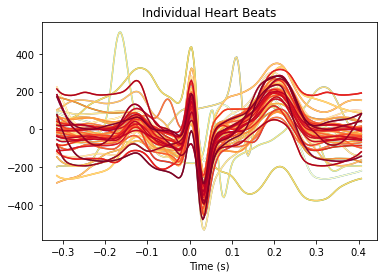

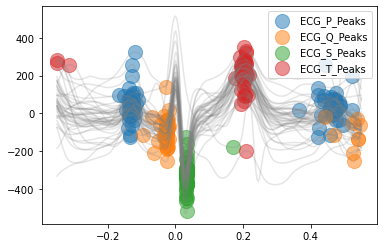

In [12]:
# class 2
plot_row(x_train, 4)

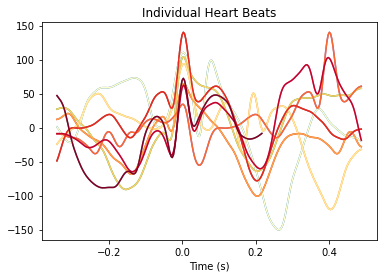

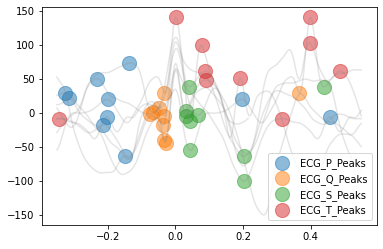

In [13]:
# class 3
plot_row(x_train, 5013)

### Test data visualization

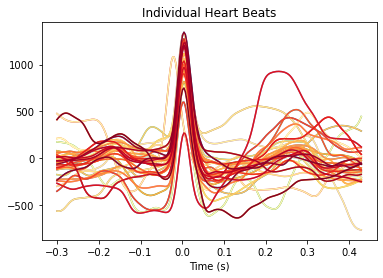

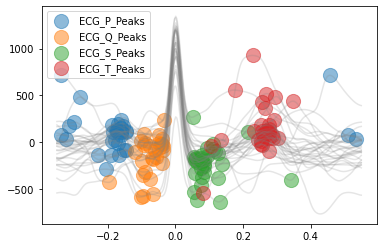

In [14]:
plot_row(x_test, 0)

,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,48.855606,1229.027778,66.988204,NaN,NaN,NaN,NaN,NaN,NaN,79.718708,...,1.386294,3.720176,1.551277,0.0,0.0,0.0,1.643468,1.814699,2.630689,1.146241


dict_keys(['ECG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2', 'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_ULF', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_VHF', 'HRV_LFHF', 'HRV_LFn', 'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S', 'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS', 'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d', 'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d', 'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa', 'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak', 'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max', 'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_Asymmetry', 'HRV_MFDFA_alpha1_Fluctuation', 'HRV_MFDFA_alpha1_Increment', 'HRV_ApE

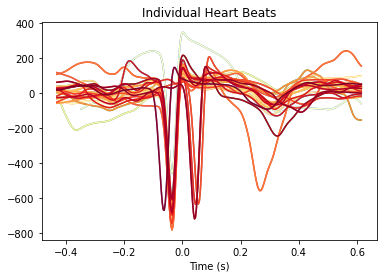

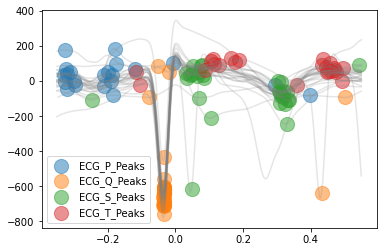

In [85]:
plot_row(x_test, 2332)

### Some useful observations
1. Some datapoint is flipped in sign (negative instead of positive amplitude)
2. At the very beginning of the recordings the signal seems to be inaccurate (very high in amplitude).

## Feature extraction with domain knowledge

TODO:
1. Morphology: https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg
2. Detect flipped data and correct them
3. What to do with signals that are too noisy? Neurokit2 can't clean them with method="neurokit"

In [96]:
def extract_feature(df_, sampling_rate=300):
    df = copy.deepcopy(df_)
    df = df.drop(["id"], axis=1)

    def _remove_nan(l):
        return [x for x in l if str(x) != "nan"]
    
    def _detect_flipped(signal, threshold=1000):
        # Heuristic: If the the min. value is too negative
        abs_max = np.max(np.abs(signal))
        pos_max = np.max(signal)
        if (abs_max > pos_max and (abs_max - pos_max) > threshold):
            return True
        return False

    def _calc_morphology(df, row_idx):
        row = df.loc[row_idx].dropna()
        # print(row_idx)
        flipped = _detect_flipped(row)
        if flipped:
            print(row_idx)
            row = -row

        clean_with_neurokit = True
        try: # In some cases when the signal is too noisy this cleaning is fail
            signals, info = nk.ecg_process(
                row, 
                sampling_rate=sampling_rate,
                method="neurokit", 
            )
            cleaned_ecg = signals["ECG_Clean"]
            epochs = nk.ecg_segment(
                cleaned_ecg, 
                rpeaks=None, 
                sampling_rate=sampling_rate, 
                show=False
            )
            _, rpeaks = nk.ecg_peaks(
                cleaned_ecg, 
                sampling_rate=sampling_rate
            )
            _, waves_peak = nk.ecg_delineate(
                cleaned_ecg, 
                rpeaks, 
                sampling_rate=SAMPLING_RATE, 
                method="dwt"
            )
        except:
            try:
                clean_with_neurokit = False
                signals, info = nk.ecg_process(
                    row, 
                    sampling_rate=sampling_rate,
                    method="hamilton2002",
                )
                cleaned_ecg = signals["ECG_Clean"]
                epochs = nk.ecg_segment(
                    cleaned_ecg, 
                    rpeaks=None, 
                    sampling_rate=sampling_rate, 
                    show=False
                )
                _, rpeaks = nk.ecg_peaks(
                    cleaned_ecg, 
                    sampling_rate=sampling_rate
                )
                _, waves_peak = nk.ecg_delineate(
                    cleaned_ecg, 
                    rpeaks, 
                    sampling_rate=SAMPLING_RATE, 
                    method="dwt"
                )
            except:
                try:
                    clean_with_neurokit = False
                    signals, info = nk.ecg_process(
                        row, 
                        sampling_rate=sampling_rate,
                        method="engzeemod2012",
                    )
                    cleaned_ecg = signals["ECG_Clean"]
                    epochs = nk.ecg_segment(
                        cleaned_ecg, 
                        rpeaks=None, 
                        sampling_rate=sampling_rate, 
                        show=False
                    )
                    _, rpeaks = nk.ecg_peaks(
                        cleaned_ecg, 
                        sampling_rate=sampling_rate
                    )
                    _, waves_peak = nk.ecg_delineate(
                        cleaned_ecg, 
                        rpeaks, 
                        sampling_rate=SAMPLING_RATE, 
                        method="dwt"
                    )
                except:
                    # https://neuropsychology.github.io/NeuroKit/functions/ecg.html?highlight=ecg_process#ecg-clean
                    raise Exception("The data is too noise to be cleaned! Please try different cleaning method")

        waves_peak = waves_peak | rpeaks # Merge two dictionaries
        peak_names = [
            'ECG_P_Peaks', 
            'ECG_P_Onsets', 
            'ECG_P_Offsets', 
            'ECG_Q_Peaks', 
            'ECG_R_Peaks',
            'ECG_R_Onsets', 
            'ECG_R_Offsets', 
            'ECG_S_Peaks', 
            'ECG_T_Peaks', 
            'ECG_T_Onsets', 
            'ECG_T_Offsets',
        ]
        
        PR_intervals = []
        PR_segments = []
        QRS_complexes = []
        QT_intervals = []
        QT_segments = []
        for epoch_idx in range(len(waves_peak["ECG_P_Onsets"])):
            p_onset = waves_peak["ECG_P_Onsets"][epoch_idx]
            p_offset = waves_peak["ECG_P_Offsets"][epoch_idx]
            r_onset = waves_peak["ECG_R_Onsets"][epoch_idx]
            r_offset = waves_peak["ECG_R_Offsets"][epoch_idx]
            t_onset = waves_peak["ECG_T_Onsets"][epoch_idx]
            t_offset = waves_peak["ECG_T_Offsets"][epoch_idx]

            if not math.isnan(p_onset) and not math.isnan(r_onset):
                PR_intervals.append(r_onset - p_onset)
            
            if not math.isnan(p_offset) and not math.isnan(r_onset):
                PR_segments.append(r_onset - p_offset)
            
            if not math.isnan(r_offset) and not math.isnan(r_onset):
                QRS_complexes.append(r_offset - r_onset)
            
            if not math.isnan(t_offset) and not math.isnan(r_onset):
                QT_intervals.append(t_offset - r_onset)
            
            if not math.isnan(t_onset) and not math.isnan(r_offset):
                QT_segments.append(t_onset - r_offset)

        
        features = {}
        warnings.filterwarnings('ignore')
        features["id"] = row_idx
        features["flipped"] = flipped
        features["clean_with_neurokit"] = clean_with_neurokit
        features["mean"] = np.mean(cleaned_ecg)
        features["var"] = np.var(cleaned_ecg)
        features["RR"] = np.median(waves_peak["ECG_R_Peaks"][1:] - waves_peak["ECG_R_Peaks"][:-1])
        features["PR_interval"] = np.median(PR_intervals)
        features["PR_segment"] = np.median(PR_segments)
        features["QRS_complex"] = np.median(QRS_complexes)
        features["QT_interval"] = np.median(QT_intervals)
        features["QT_segment"] = np.median(QT_segments)
        features["P"] = np.median(cleaned_ecg[_remove_nan(waves_peak["ECG_P_Peaks"])])
        features["Q"] = np.median(cleaned_ecg[_remove_nan(waves_peak["ECG_Q_Peaks"])])
        features["R"] = np.median(cleaned_ecg[_remove_nan(waves_peak["ECG_R_Peaks"])])
        features["S"] = np.median(cleaned_ecg[_remove_nan(waves_peak["ECG_S_Peaks"])])
        features["T"] = np.median(cleaned_ecg[_remove_nan(waves_peak["ECG_T_Peaks"])])

        columns_selection = ['ECG_Rate_Mean', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD',
        'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
        'HRV_IQRNN', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_pNN20',
        'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'HRV_VHF',
        'HRV_HFn', 'HRV_LnHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_S',
        'HRV_CSI', 'HRV_CVI', 'HRV_CSI_Modified', 'HRV_PIP', 'HRV_IALS',
        'HRV_PSS', 'HRV_PAS', 'HRV_GI', 'HRV_SI', 'HRV_AI', 'HRV_PI', 'HRV_C1d',
        'HRV_C1a', 'HRV_SD1d', 'HRV_SD1a', 'HRV_C2d', 'HRV_C2a', 'HRV_SD2d',
        'HRV_SD2a', 'HRV_Cd', 'HRV_Ca', 'HRV_SDNNd', 'HRV_SDNNa',
        'HRV_DFA_alpha1', 'HRV_MFDFA_alpha1_Width', 'HRV_MFDFA_alpha1_Peak',
        'HRV_MFDFA_alpha1_Mean', 'HRV_MFDFA_alpha1_Max',
        'HRV_MFDFA_alpha1_Delta', 'HRV_MFDFA_alpha1_Asymmetry',
        'HRV_MFDFA_alpha1_Fluctuation', 'HRV_MFDFA_alpha1_Increment',
        'HRV_ApEn', 'HRV_ShanEn', 'HRV_FuzzyEn', 'HRV_MSEn', 'HRV_CMSEn',
        'HRV_RCMSEn', 'HRV_CD', 'HRV_HFD', 'HRV_KFD', 'HRV_LZC',
        'HRV_DFA_alpha2', 'HRV_MFDFA_alpha2_Width', 'HRV_MFDFA_alpha2_Peak',
        'HRV_MFDFA_alpha2_Mean', 'HRV_MFDFA_alpha2_Max',
        'HRV_MFDFA_alpha2_Delta', 'HRV_MFDFA_alpha2_Asymmetry',
        'HRV_MFDFA_alpha2_Fluctuation', 'HRV_MFDFA_alpha2_Increment']
        try:
            analysis = nk.ecg_analyze(
                signals,
                sampling_rate=sampling_rate,
                method="auto"
            ).to_dict()
            for k, v in analysis.items():
                if k in columns_selection:
                    features[k] = v[0]
        except: # Fill in NAs
            for key in columns_selection:
                features[key] = np.nan

        return features
    
    res = Parallel(n_jobs=4)(delayed(_calc_morphology)(df, i) for i in tqdm(range(len(df))))

    def _convert_to_dict_list(d):
        d = [x for x in d if x is not None]
        return {k: [dic[k] for dic in d] for k in d[0]}

    res = _convert_to_dict_list(res)
    return pd.DataFrame.from_dict(res)


In [61]:
train_feat = extract_feature(x_train)
train_feat

  0%|          | 0/5117 [00:00<?, ?it/s]

** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an illegal value
18
** On entry to DGELSD, parameter number  6 had an illegal value
42
** On entry to DGELSD, parameter number  6 had an illegal value
62
** On entry to DGELSD, parameter number  6 had an illegal value
83
84
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an illegal value
113
117
140
156
** On entry to DGELSD, parameter number  6 had an illegal value
201
** On entry to DGELSD, parameter number  6 had an illegal value
223
224
244
263
** On entry to DGELSD, parameter number  6 had an illegal value
267
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an

,id,flipped,clean_with_neurokit,mean,var,RR,PR_interval,PR_segment,QRS_complex,QT_interval,...,HRV_ApEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,0,False,True,0.402082,9901.107523,249.0,29.5,-10.0,52.0,135.0,...,0.507148,4.141017,0.385663,0.216039,0.380920,0.355285,0.790085,1.704280,1.194765,0.457909
1,1,False,True,5.874702,15758.111304,239.0,31.0,-10.0,51.0,122.5,...,0.275408,4.707715,1.133431,0.000000,0.000000,0.000000,1.762569,1.673112,2.196774,0.879306
2,2,False,True,-0.068424,28028.310132,272.0,20.0,-13.5,54.0,159.0,...,0.415806,4.237291,1.425803,0.000000,0.000000,0.000000,1.929675,1.732052,2.358072,1.340133
3,3,False,True,0.552108,31321.373855,115.0,30.0,-14.0,53.0,66.5,...,0.487645,4.824271,1.395006,0.000000,1.017163,1.277857,1.643608,1.882645,2.419543,1.090850
4,4,False,True,1.248736,17281.252902,180.0,21.5,-11.0,50.0,115.0,...,0.400753,4.381316,0.591076,0.318809,0.273941,0.265536,1.292900,1.417458,1.487845,0.610206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,5112,False,True,-3.899093,97805.464176,250.5,55.0,17.5,40.0,118.5,...,0.290702,4.106603,0.968756,NaN,NaN,NaN,0.790514,1.876664,2.601532,1.464106
5113,5113,False,True,0.049182,4651.009266,259.0,19.0,-11.0,50.0,109.0,...,0.104728,3.252426,1.140114,NaN,NaN,NaN,2.149990,1.822316,1.757852,1.278502
5114,5114,False,True,2.501117,27261.662882,237.0,26.0,-12.0,54.0,131.5,...,0.282082,4.786426,0.660790,0.000000,0.000000,0.000000,1.535058,1.333042,1.417135,0.439653
5115,5115,False,True,0.112977,3879.453834,254.0,39.5,-7.0,47.0,136.5,...,0.101368,4.051109,1.405816,NaN,NaN,NaN,1.828850,2.037834,3.045494,1.093750


In [62]:
np.sum(train_feat["flipped"] == True)

330

In [100]:
np.sum(train_feat["clean_with_neurokit"] == False)

4

In [63]:
train_feat.to_csv("data/train_features.csv", index=False)

In [97]:
test_feat = extract_feature(x_test)
test_feat

  0%|          | 0/3411 [00:00<?, ?it/s]

/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in

** On entry to DGELSD, parameter number  6 had an illegal value


/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kvu/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


** On entry to DGELSD, parameter number  6 had an illegal value
15
** On entry to DGELSD, parameter number  6 had an illegal value
30
54
56
67
** On entry to DGELSD, parameter number  6 had an illegal value
84
** On entry to DGELSD, parameter number  6 had an illegal value
96
** On entry to DGELSD, parameter number  6 had an illegal value
104
** On entry to DGELSD, parameter number  6 had an illegal value
113
** On entry to DGELSD, parameter number  6 had an illegal value
118
123
124
** On entry to DGELSD, parameter number  6 had an illegal value
152
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an illegal value
163
181
** On entry to DGELSD, parameter number  6 had an illegal value
193
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, parameter number  6 had an illegal value
230
231
237
242
** On entry to DGELSD, parameter number  6 had an illegal value
** On entry to DGELSD, paramete

,id,flipped,clean_with_neurokit,mean,var,RR,PR_interval,PR_segment,QRS_complex,QT_interval,...,HRV_ApEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,0,False,True,-0.073587,73732.729908,252.0,43.0,12.0,64.5,129.0,...,0.447378,4.192595,0.669809,0.000000,0.000000,0.000000,1.482393,1.307762,1.496524,0.479438
1,1,False,True,0.659570,20548.485245,321.0,27.5,-13.5,85.0,174.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,False,True,1.244914,55068.539640,293.0,57.0,18.0,35.0,125.0,...,0.156952,4.773557,1.050966,0.000000,0.000000,0.000000,1.317997,1.823434,2.190935,1.144941
3,3,False,True,-0.151816,7865.687206,288.0,30.5,-11.5,66.5,141.0,...,0.392393,3.767376,1.609551,NaN,NaN,NaN,1.922481,1.909094,2.347472,1.373530
4,4,False,True,0.271470,22106.590088,299.0,41.0,12.0,51.5,136.5,...,0.216310,4.356558,1.589772,NaN,NaN,NaN,1.722961,2.015078,3.598669,1.232749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,3406,True,True,-0.062916,15665.043557,207.5,45.0,24.5,31.0,112.5,...,0.255852,4.721928,0.743384,0.264342,0.338812,0.326057,1.013332,1.963479,2.374257,0.931337
3407,3407,False,True,-0.862846,22245.551130,294.0,30.0,-10.0,42.0,133.0,...,0.602064,4.542748,1.051771,0.000000,0.000000,0.000000,1.595832,1.960720,2.615343,0.958877
3408,3408,False,True,0.480116,13052.577102,228.0,27.0,-6.5,47.0,115.0,...,0.488742,5.448699,1.382796,0.833051,1.006338,1.119334,2.099463,1.770935,3.436644,1.039394
3409,3409,False,True,-0.495431,6857.557399,220.0,19.0,-12.0,46.5,133.0,...,0.309562,3.136379,0.922728,0.768173,0.722593,0.768173,1.540892,1.590685,2.045740,0.552413


In [99]:
np.sum(test_feat["clean_with_neurokit"] == False)

3

In [98]:
test_feat.to_csv("data/test_features.csv", index=False)

## Merge x_train with y_train

In [103]:
df = train_feat.merge(y_train, on=["id"])
df

,id,flipped,clean_with_neurokit,mean,var,RR,PR_interval,PR_segment,QRS_complex,QT_interval,...,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,y
0,0,False,True,0.402082,9901.107523,249.0,29.5,-10.0,52.0,135.0,...,4.141017,0.385663,0.216039,0.380920,0.355285,0.790085,1.704280,1.194765,0.457909,0
1,1,False,True,5.874702,15758.111304,239.0,31.0,-10.0,51.0,122.5,...,4.707715,1.133431,0.000000,0.000000,0.000000,1.762569,1.673112,2.196774,0.879306,0
2,2,False,True,-0.068424,28028.310132,272.0,20.0,-13.5,54.0,159.0,...,4.237291,1.425803,0.000000,0.000000,0.000000,1.929675,1.732052,2.358072,1.340133,0
3,3,False,True,0.552108,31321.373855,115.0,30.0,-14.0,53.0,66.5,...,4.824271,1.395006,0.000000,1.017163,1.277857,1.643608,1.882645,2.419543,1.090850,1
4,4,False,True,1.248736,17281.252902,180.0,21.5,-11.0,50.0,115.0,...,4.381316,0.591076,0.318809,0.273941,0.265536,1.292900,1.417458,1.487845,0.610206,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,5112,False,True,-3.899093,97805.464176,250.5,55.0,17.5,40.0,118.5,...,4.106603,0.968756,NaN,NaN,NaN,0.790514,1.876664,2.601532,1.464106,3
5113,5113,False,True,0.049182,4651.009266,259.0,19.0,-11.0,50.0,109.0,...,3.252426,1.140114,NaN,NaN,NaN,2.149990,1.822316,1.757852,1.278502,0
5114,5114,False,True,2.501117,27261.662882,237.0,26.0,-12.0,54.0,131.5,...,4.786426,0.660790,0.000000,0.000000,0.000000,1.535058,1.333042,1.417135,0.439653,0
5115,5115,False,True,0.112977,3879.453834,254.0,39.5,-7.0,47.0,136.5,...,4.051109,1.405816,NaN,NaN,NaN,1.828850,2.037834,3.045494,1.093750,0


## Classes

In [104]:
# unique classes
np.unique(df["y"])

array([0, 1, 2, 3])

In [105]:
for x in np.unique(df["y"]):
    class_size = len(df[df["y"] == x])
    print(f"Class {x} occupies {class_size * 100 / len(df):.5f}%")

Class 0 occupies 59.21438%
Class 1 occupies 8.65742%
Class 2 occupies 28.80594%
Class 3 occupies 3.32226%


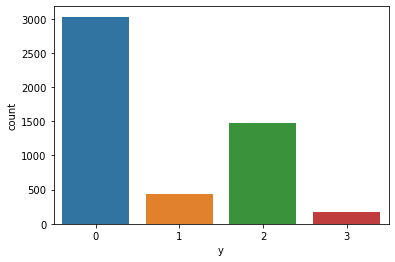

In [106]:
sns.countplot(data=df, x="y");

## K Fold split

In [107]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
classes = df["y"]
df["fold"] = 0

for fold_id, (train_index, val_index) in enumerate(skf.split(df, classes)):
    df.loc[val_index, "fold"] = fold_id

df

,id,flipped,clean_with_neurokit,mean,var,RR,PR_interval,PR_segment,QRS_complex,QT_interval,...,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,y,fold
0,0,False,True,0.402082,9901.107523,249.0,29.5,-10.0,52.0,135.0,...,0.385663,0.216039,0.380920,0.355285,0.790085,1.704280,1.194765,0.457909,0,1
1,1,False,True,5.874702,15758.111304,239.0,31.0,-10.0,51.0,122.5,...,1.133431,0.000000,0.000000,0.000000,1.762569,1.673112,2.196774,0.879306,0,0
2,2,False,True,-0.068424,28028.310132,272.0,20.0,-13.5,54.0,159.0,...,1.425803,0.000000,0.000000,0.000000,1.929675,1.732052,2.358072,1.340133,0,3
3,3,False,True,0.552108,31321.373855,115.0,30.0,-14.0,53.0,66.5,...,1.395006,0.000000,1.017163,1.277857,1.643608,1.882645,2.419543,1.090850,1,4
4,4,False,True,1.248736,17281.252902,180.0,21.5,-11.0,50.0,115.0,...,0.591076,0.318809,0.273941,0.265536,1.292900,1.417458,1.487845,0.610206,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,5112,False,True,-3.899093,97805.464176,250.5,55.0,17.5,40.0,118.5,...,0.968756,NaN,NaN,NaN,0.790514,1.876664,2.601532,1.464106,3,4
5113,5113,False,True,0.049182,4651.009266,259.0,19.0,-11.0,50.0,109.0,...,1.140114,NaN,NaN,NaN,2.149990,1.822316,1.757852,1.278502,0,1
5114,5114,False,True,2.501117,27261.662882,237.0,26.0,-12.0,54.0,131.5,...,0.660790,0.000000,0.000000,0.000000,1.535058,1.333042,1.417135,0.439653,0,2
5115,5115,False,True,0.112977,3879.453834,254.0,39.5,-7.0,47.0,136.5,...,1.405816,NaN,NaN,NaN,1.828850,2.037834,3.045494,1.093750,0,1


In [108]:
df = df.sort_values(by=["fold"], ignore_index=True)
df

,id,flipped,clean_with_neurokit,mean,var,RR,PR_interval,PR_segment,QRS_complex,QT_interval,...,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC,y,fold
0,2558,False,True,0.720888,11199.328241,186.0,53.0,23.0,41.0,108.0,...,0.725906,0.000000,0.000000,0.000000,0.711332,2.107606,4.930854,1.172408,1,0
1,2255,False,True,0.291276,18221.578472,381.5,102.0,60.0,63.0,151.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0
2,2253,False,True,-4.777004,33118.237938,225.0,64.0,27.0,34.0,128.0,...,0.989085,0.000000,0.000000,0.000000,1.704964,1.745714,1.694755,0.586204,0,0
3,2250,False,True,0.274216,36283.845873,194.0,20.0,-11.0,50.5,122.0,...,1.396813,0.000000,0.549306,0.823959,2.414271,1.816574,2.300383,0.898720,0,0
4,2248,False,True,1.246710,51140.848833,263.5,33.0,-12.0,48.0,126.0,...,1.725406,0.000000,0.000000,0.000000,1.774758,1.979668,4.309180,1.278502,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,4244,False,True,0.239815,51248.771107,257.5,39.0,6.0,50.0,121.0,...,0.743698,0.000000,0.000000,0.000000,1.548308,1.531784,1.529896,0.764302,0,4
5113,1456,False,True,0.627592,10055.635134,200.5,39.0,14.0,40.5,110.0,...,0.813251,0.177350,0.205413,0.205783,0.627856,2.028820,5.271486,1.104827,2,4
5114,3239,True,True,2.264877,75961.524819,195.5,62.5,34.5,35.0,107.0,...,0.992374,0.650672,0.000000,0.000000,1.722870,1.881462,3.609321,1.084185,2,4
5115,1461,False,True,-1.369990,13214.103631,225.0,17.0,-12.0,61.5,128.0,...,0.607009,0.358423,0.374211,0.371246,0.908619,1.891341,2.097060,0.828620,2,4


In [22]:
df.to_csv("data/kfold.csv", index=False)